In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [42]:
warnings.filterwarnings("ignore")
!ls

 CSAW-HackML-2020   bd_valid.h5     'model_X=2.h5'   test.h5
 bd_test.h5	   'model_X=10.h5'  'model_X=4.h5'   valid.h5


In [43]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git
!ls CSAW-HackML-2020/lab3/models

fatal: destination path 'CSAW-HackML-2020' already exists and is not an empty directory.
bd_net.h5  bd_weights.h5


In [44]:
!conda install -y gdown


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.



In [ ]:
!gdown --id 1JpoJEQV00rk5ZhOKbNpDWMVHoK43PN7s
!gdown --id 14xUWQSEpUvYWLvZWxZbM0Ud845bELwby
!gdown --id 1vr8hLQSea0fOaFGj2rOvFrggTtTali5I
!gdown --id 1LqaPMuRlK-tu2Byn778nk8eaezf_pYhw

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1JpoJEQV00rk5ZhOKbNpDWMVHoK43PN7s
From (redirected): https://drive.google.com/uc?id=1JpoJEQV00rk5ZhOKbNpDWMVHoK43PN7s&confirm=t&uuid=f0422c28-155b-47cf-a2f2-4b83aa61795f
To: /kaggle/working/bd_test.h5
100%|█████████████████████████████████████████| 398M/398M [00:03<00:00, 131MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=14xUWQSEpUvYWLvZWxZbM0Ud845bELwby
From (redirected): https://drive.google.com/uc?id=14xUWQSEpUvYWLvZWxZbM0Ud845bELwby&confirm=t&uuid=22d6d2c3-f3cb-4ac1-bbd0-574

In [ ]:
!ls


In [ ]:
!ls CSAW-HackML-2020/lab3/models

# BD_Net

In [ ]:
import h5py
import numpy as np
import keras

# File paths
clean_dataset_path = 'valid.h5'
poisoned_dataset_path = 'bd_valid.h5'
neural_network_model_path = 'CSAW-HackML-2020/lab3/models/bd_net.h5'

def load_dataset(file_path):
    dataset = h5py.File(file_path, 'r')
    images = np.array(dataset['data']).transpose((0,2,3,1))
    labels = np.array(dataset['label'])

    return images, labels

def evaluate_model():
    # Load datasets
    clean_images, clean_labels = load_dataset(clean_dataset_path)
    poisoned_images, poisoned_labels = load_dataset(poisoned_dataset_path)

    # Load pre-trained model
    trained_model = keras.models.load_model(neural_network_model_path)

    # Evaluate clean data
    clean_predictions = np.argmax(trained_model.predict(clean_images), axis=1)
    clean_data_accuracy = np.mean(clean_predictions == clean_labels) * 100
    print('Accuracy on Clean Data:', clean_data_accuracy)

    # Evaluate poisoned data
    poisoned_predictions = np.argmax(trained_model.predict(poisoned_images), axis=1)
    attack_success_rate = np.mean(poisoned_predictions == poisoned_labels) * 100
    print('Attack Success Rate:', attack_success_rate)

if __name__ == '__main__':
    evaluate_model()


In [ ]:
import keras

# Load the pre-trained model
trained_neural_network = keras.models.load_model(neural_network_model_path)

# Display the summary of the model
model_details = trained_neural_network.summary()
print(model_details)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load clean data
x_clean, y_clean = load_dataset(clean_dataset_path)

# Display images from clean data
clean_data_fig = plt.figure(figsize=(10, 8))
columns, rows = 3, 3
for i in range(1, columns * rows + 1):
    random_index = np.random.randint(x_clean.shape[0], size=1)
    image, label = x_clean[random_index], y_clean[random_index]
    clean_data_fig.add_subplot(rows, columns, i)
    plt.title(f"True Label: {label[0]}")
    plt.axis("off")
    plt.imshow(image[0] / 255)
plt.show()

In [ ]:
# Load poisoned data
x_poisoned, y_poisoned = load_dataset(poisoned_dataset_path)

# Display images from poisoned data
poisoned_data_fig = plt.figure(figsize=(10, 8))
for i in range(1, columns * rows + 1):
    random_index = np.random.randint(x_poisoned.shape[0], size=1)
    image, label = x_poisoned[random_index], y_poisoned[random_index]
    poisoned_data_fig.add_subplot(rows, columns, i)
    plt.title(f"True Label: {label[0]}")
    plt.axis("off")
    plt.imshow(image[0] / 255)
plt.show()


# Prune Defense 

In [ ]:
import numpy as np
import keras
import gc
from tensorflow.keras import backend as K
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load clean and poisoned data
clean_test_data, clean_test_labels = load_dataset(clean_dataset_path)
poisoned_test_data, poisoned_test_labels = load_dataset(poisoned_dataset_path)

# Clear Keras session and collect garbage
K.clear_session()
gc.collect()

In [53]:
# Original accuracy of the clean data
original_clean_accuracy = 98.423833030224

# Clone the model and set weights
model_cloned = keras.models.clone_model(trained_neural_network)
model_cloned.set_weights(trained_neural_network.get_weights())

# Initialize variables
pruning_indices = []
accuracy_clean_data = []
attack_success_rates = []
model_saved_flags = np.zeros(3, dtype=bool)

# Get activation from 'pool_3' layer
layer_activation = model_cloned.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=model_cloned.input, outputs=layer_activation)
intermediate_output = intermediate_model.predict(clean_test_data)
average_activation = np.mean(intermediate_output, axis=(0, 1, 2))
sorted_indices = np.argsort(average_activation)

# Weights and biases from the 5th layer
layer_weights = model_cloned.layers[5].get_weights()[0]
layer_biases = model_cloned.layers[5].get_weights()[1]

# Pruning process
for channel in tqdm(sorted_indices):
    layer_weights[:, :, :, channel] = 0
    layer_biases[channel] = 0
    model_cloned.layers[5].set_weights([layer_weights, layer_biases])

    # Evaluate model on clean data
    predicted_labels_clean = np.argmax(model_cloned.predict(clean_test_data), axis=1)
    current_accuracy = np.mean(predicted_labels_clean == clean_test_labels) * 100
    accuracy_clean_data.append(current_accuracy)

    # Save model at specific accuracy drops
    for threshold, flag_index in zip([2, 4, 10], range(3)):
        if original_clean_accuracy - current_accuracy >= threshold and not model_saved_flags[flag_index]:
            model_cloned.save(f'model_X={threshold}.h5')
            model_saved_flags[flag_index] = 1

    # Evaluate model on poisoned data
    predicted_labels_poisoned = np.argmax(model_cloned.predict(poisoned_test_data), axis=1)
    attack_success_rate = np.mean(predicted_labels_poisoned == poisoned_test_labels) * 100
    attack_success_rates.append(attack_success_rate)

    # Clear session and collect garbage
    K.clear_session()
    gc.collect()


361/361 [==============================] - 1s 2ms/step


 22%|██▏       | 13/60 [01:00<03:43,  4.75s/it]

361/361 [==============================] - 1s 2ms/step


 23%|██▎       | 14/60 [01:05<03:37,  4.73s/it]

361/361 [==============================] - 1s 2ms/step


 25%|██▌       | 15/60 [01:09<03:31,  4.71s/it]

361/361 [==============================] - 1s 2ms/step


 27%|██▋       | 16/60 [01:14<03:26,  4.70s/it]

361/361 [==============================] - 1s 2ms/step


 28%|██▊       | 17/60 [01:19<03:21,  4.68s/it]

361/361 [==============================] - 1s 2ms/step


 30%|███       | 18/60 [01:23<03:16,  4.68s/it]

361/361 [==============================] - 1s 2ms/step


 32%|███▏      | 19/60 [01:28<03:10,  4.66s/it]

361/361 [==============================] - 1s 2ms/step


 33%|███▎      | 20/60 [01:33<03:06,  4.66s/it]

361/361 [==============================] - 1s 2ms/step


 35%|███▌      | 21/60 [01:37<03:01,  4.65s/it]

361/361 [==============================] - 1s 2ms/step


 37%|███▋      | 22/60 [01:42<02:56,  4.64s/it]

361/361 [==============================] - 1s 2ms/step


 38%|███▊      | 23/60 [01:46<02:51,  4.64s/it]

361/361 [==============================] - 1s 2ms/step


 40%|████      | 24/60 [01:51<02:46,  4.63s/it]

361/361 [==============================] - 1s 2ms/step


 42%|████▏     | 25/60 [01:56<02:42,  4.64s/it]

361/361 [==============================] - 1s 2ms/step


 43%|████▎     | 26/60 [02:00<02:37,  4.63s/it]

361/361 [==============================] - 1s 2ms/step


 45%|████▌     | 27/60 [02:05<02:33,  4.66s/it]

361/361 [==============================] - 1s 2ms/step


 47%|████▋     | 28/60 [02:10<02:28,  4.65s/it]

361/361 [==============================] - 1s 2ms/step


 48%|████▊     | 29/60 [02:14<02:23,  4.64s/it]

361/361 [==============================] - 1s 2ms/step


 50%|█████     | 30/60 [02:19<02:19,  4.64s/it]

361/361 [==============================] - 1s 2ms/step


 52%|█████▏    | 31/60 [02:24<02:14,  4.63s/it]

361/361 [==============================] - 1s 2ms/step


 53%|█████▎    | 32/60 [02:28<02:09,  4.63s/it]

361/361 [==============================] - 1s 2ms/step


 55%|█████▌    | 33/60 [02:33<02:06,  4.68s/it]

361/361 [==============================] - 1s 2ms/step


 57%|█████▋    | 34/60 [02:38<02:01,  4.68s/it]

361/361 [==============================] - 1s 2ms/step


 58%|█████▊    | 35/60 [02:42<01:56,  4.66s/it]

361/361 [==============================] - 1s 2ms/step


 60%|██████    | 36/60 [02:47<01:52,  4.68s/it]

361/361 [==============================] - 1s 2ms/step


 62%|██████▏   | 37/60 [02:52<01:47,  4.67s/it]

361/361 [==============================] - 1s 2ms/step


 63%|██████▎   | 38/60 [02:56<01:42,  4.66s/it]

361/361 [==============================] - 1s 2ms/step


 65%|██████▌   | 39/60 [03:01<01:37,  4.66s/it]

361/361 [==============================] - 1s 2ms/step


 67%|██████▋   | 40/60 [03:06<01:33,  4.68s/it]

361/361 [==============================] - 1s 2ms/step


 68%|██████▊   | 41/60 [03:10<01:28,  4.67s/it]

361/361 [==============================] - 1s 2ms/step


 70%|███████   | 42/60 [03:15<01:24,  4.67s/it]

361/361 [==============================] - 1s 2ms/step


 72%|███████▏  | 43/60 [03:20<01:19,  4.67s/it]

361/361 [==============================] - 1s 2ms/step


 73%|███████▎  | 44/60 [03:24<01:14,  4.66s/it]

361/361 [==============================] - 1s 2ms/step


 75%|███████▌  | 45/60 [03:29<01:10,  4.67s/it]

361/361 [==============================] - 1s 2ms/step


 77%|███████▋  | 46/60 [03:34<01:05,  4.67s/it]

361/361 [==============================] - 1s 2ms/step


 78%|███████▊  | 47/60 [03:38<01:01,  4.70s/it]

361/361 [==============================] - 1s 2ms/step


 80%|████████  | 48/60 [03:43<00:56,  4.69s/it]

361/361 [==============================] - 1s 2ms/step


 82%|████████▏ | 49/60 [03:48<00:51,  4.69s/it]

361/361 [==============================] - 1s 2ms/step


 83%|████████▎ | 50/60 [03:52<00:46,  4.68s/it]

361/361 [==============================] - 1s 2ms/step


 85%|████████▌ | 51/60 [03:57<00:42,  4.68s/it]

361/361 [==============================] - 1s 2ms/step


 87%|████████▋ | 52/60 [04:02<00:37,  4.68s/it]

361/361 [==============================] - 1s 2ms/step


 88%|████████▊ | 53/60 [04:07<00:33,  4.79s/it]

361/361 [==============================] - 1s 2ms/step


 90%|█████████ | 54/60 [04:11<00:28,  4.75s/it]

361/361 [==============================] - 1s 2ms/step


 92%|█████████▏| 55/60 [04:16<00:23,  4.72s/it]

361/361 [==============================] - 1s 2ms/step


 93%|█████████▎| 56/60 [04:21<00:18,  4.70s/it]

361/361 [==============================] - 1s 2ms/step


 95%|█████████▌| 57/60 [04:25<00:14,  4.69s/it]

361/361 [==============================] - 1s 2ms/step


 97%|█████████▋| 58/60 [04:30<00:09,  4.67s/it]

361/361 [==============================] - 1s 2ms/step


 98%|█████████▊| 59/60 [04:35<00:04,  4.67s/it]

361/361 [==============================] - 1s 2ms/step


100%|██████████| 60/60 [04:40<00:00,  4.67s/it]


In [54]:
print("clean_accuracy: ",accuracy_clean_data)
print("attack success rate: ",attack_success_rates)

clean_accuracy:  [98.4238330302243, 98.44981380445137, 98.44981380445137, 98.44981380445137, 98.44981380445137, 98.44115354637569, 98.44115354637569, 98.44981380445137, 98.45847406252707, 98.44981380445137, 98.44115354637569, 98.44981380445137, 98.44981380445137, 98.44981380445137, 98.44981380445137, 98.44981380445137, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.44115354637569, 98.4324932883, 98.40651251407292, 98.37187148177016, 98.03412141681822, 97.98215986836408, 97.47986489997402, 97.34130077076297, 95.60058889754914, 95.06365289685633, 94.59599896076904, 92.02390231228891, 91.42634450506625, 90.96735082705464, 89.10539534078116, 84.38555468952976,

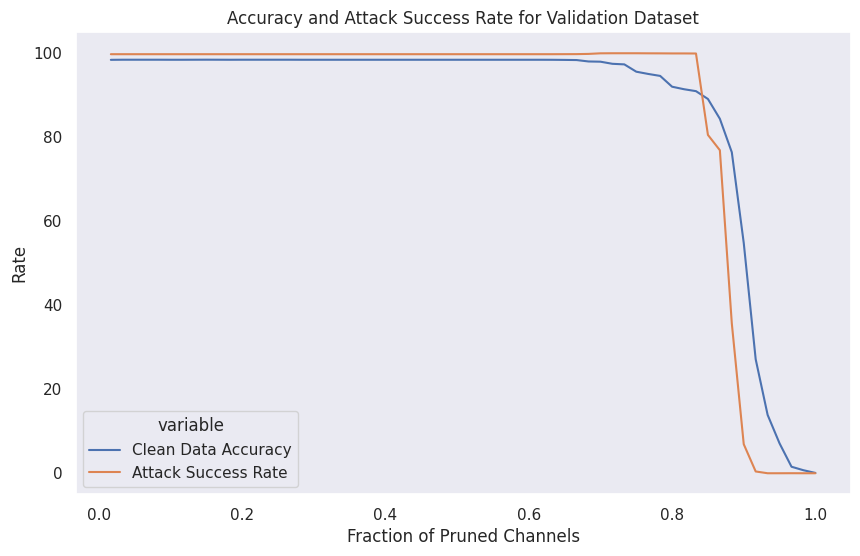

In [55]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for plotting
data = {
    'Fraction of Pruned Channels': np.arange(1, 61) / 60,
    'Clean Data Accuracy': accuracy_clean_data,
    'Attack Success Rate': attack_success_rates
}
df = pd.DataFrame(data)

# Plotting using Seaborn
# sns.set_palette("bright")
sns.set_theme(style="dark")
plt.figure(figsize=(10, 6))
sns.lineplot(x='Fraction of Pruned Channels', y='value', hue='variable', 
             data=pd.melt(df, ['Fraction of Pruned Channels']))

plt.title("Accuracy and Attack Success Rate for Validation Dataset")
plt.ylabel("Rate")
plt.show()


# combined model

In [56]:
import numpy as np
import keras
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combined model class
class CombinedModel(keras.Model):
    def __init__(self, base_model, alternate_model):
        super(CombinedModel, self).__init__()
        self.base_model = base_model
        self.alternate_model = alternate_model

    def predict(self, input_data):
        base_predictions = np.argmax(self.base_model(input_data), axis=1)
        alternate_predictions = np.argmax(self.alternate_model(input_data), axis=1)
        combined_predictions = np.zeros(input_data.shape[0])
        for i in range(input_data.shape[0]):
            combined_predictions[i] = base_predictions[i] if base_predictions[i] == alternate_predictions[i] else 1283
        return combined_predictions

In [57]:
test_data_filename = 'test.h5'
poisoned_test_data_filename = 'bd_test.h5'
test_model_X_2_filename = 'model_X=2.h5'
test_model_X_4_filename = 'model_X=4.h5'
test_model_X_10_filename = 'model_X=10.h5'
# Load test data
test_data, test_labels = load_dataset(test_data_filename)
poisoned_test_data, poisoned_test_labels = load_dataset(poisoned_test_data_filename)

# Load models
model_2_percent = keras.models.load_model(test_model_X_2_filename)
model_4_percent = keras.models.load_model(test_model_X_4_filename)
model_10_percent = keras.models.load_model(test_model_X_10_filename)



In [58]:
# Create combined models
combined_model_2 = CombinedModel(trained_neural_network, model_2_percent)
combined_model_4 = CombinedModel(trained_neural_network, model_4_percent)
combined_model_10 = CombinedModel(trained_neural_network, model_10_percent)

In [59]:
# Clear session and collect garbage
K.clear_session()
gc.collect()

10038

401/401 [==============================] - 1s 2ms/step
2%% drops model, Clean Test Data Classification Accuracy: 95.90023382696803
401/401 [==============================] - 1s 2ms/step
2%% drops model, Attack Success Rate: 100.0
401/401 [==============================] - 1s 2ms/step
4%% drops model, Clean Test Data Classification Accuracy: 92.29150428682775
401/401 [==============================] - 1s 2ms/step
4%% drops model, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 1s 2ms/step
10%% drops model, Clean Test Data Classification Accuracy: 84.54403741231489
401/401 [==============================] - 1s 2ms/step
10%% drops model, Attack Success Rate: 77.20966484801247


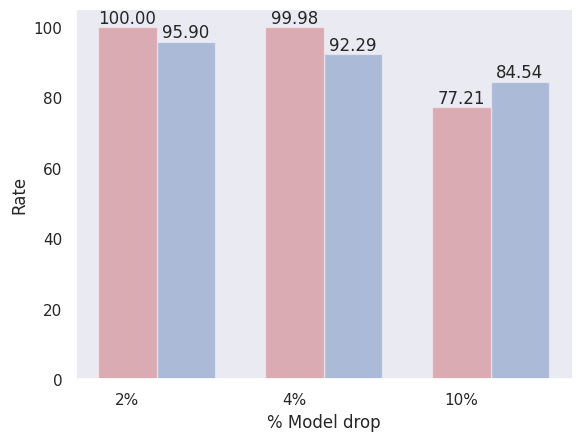

In [62]:
# Evaluate repaired models
def evaluate_model(repaired_model, test_data, test_labels, poisoned_data, poisoned_labels, drop_percentage):
    clean_label_predictions = np.argmax(repaired_model.predict(test_data), axis=1)
    clean_accuracy = np.mean(clean_label_predictions == test_labels) * 100
    print(f'{drop_percentage}% drops model, Clean Test Data Classification Accuracy:', clean_accuracy)

    poisoned_label_predictions = np.argmax(repaired_model.predict(poisoned_data), axis=1)
    attack_success_rate = np.mean(poisoned_label_predictions == poisoned_labels) * 100
    print(f'{drop_percentage}% drops model, Attack Success Rate:', attack_success_rate)
    return clean_accuracy, attack_success_rate

# Evaluate each model
accuracy_2, asr_2 = evaluate_model(model_2_percent, test_data, test_labels, poisoned_test_data, poisoned_test_labels, "2%")
accuracy_4, asr_4 = evaluate_model(model_4_percent, test_data, test_labels, poisoned_test_data, poisoned_test_labels, "4%")
accuracy_10, asr_10 = evaluate_model(model_10_percent, test_data, test_labels, poisoned_test_data, poisoned_test_labels, "10%")

# Prepare data for plotting
test_accuracies = [accuracy_2, accuracy_4, accuracy_10]
attack_rates = [asr_2, asr_4, asr_10]
plot_data = {
    "Test Accuracy": test_accuracies,
    "Attack Rate": attack_rates,
    "Model": ["Repaired 2%", "Repaired 4%", "Repaired 10%"]
}
df = pd.DataFrame(plot_data)
df.set_index('Model')



plt.xlabel('% Model drop')
plt.ylabel('Rate')

plt.xticks(range(len(test_accuracies)), ['2%', '4%', '10%'])
bar1 = plt.bar(np.arange(len(test_accuracies)) + bar_width, test_accuracies, bar_width, alpha=opacity, color='b', label='Accuracy')
bar2 = plt.bar(range(len(attack_rates)), attack_rates, bar_width, alpha=opacity, color='r', label='Attack Rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')



sns.despine()
plt.show()

Combined 2% drops model, Clean Test Data Classification Accuracy: 95.74434918160561
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, Clean Test Data Classification Accuracy: 92.1278254091972
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, Clean Test Data Classification Accuracy: 84.3335931410756
Combined 10% drops model, Attack Success Rate: 77.20966484801247


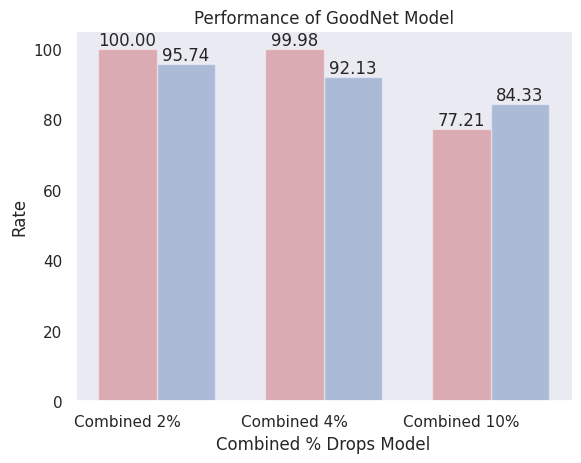

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate the combined model
def evaluate_combined_model(combined_model, test_data, test_labels, poisoned_data, poisoned_labels, drop_percentage):
    # Predictions on clean and poisoned data
    clean_predictions = combined_model.predict(test_data)
    poisoned_predictions = combined_model.predict(poisoned_data)

    # Calculate accuracy and attack success rate
    accuracy = np.mean(clean_predictions == test_labels) * 100
    attack_success_rate = np.mean(poisoned_predictions == poisoned_labels) * 100

    print(f'Combined {drop_percentage} drops model, Clean Test Data Classification Accuracy: {accuracy}')
    print(f'Combined {drop_percentage} drops model, Attack Success Rate: {attack_success_rate}')

    return accuracy, attack_success_rate

# Evaluate combined models
accuracy_2, asr_2 = evaluate_combined_model(combined_model_2, test_data, test_labels, poisoned_test_data, poisoned_test_labels, "2%")
accuracy_4, asr_4 = evaluate_combined_model(combined_model_4, test_data, test_labels, poisoned_test_data, poisoned_test_labels, "4%")
accuracy_10, asr_10 = evaluate_combined_model(combined_model_10,test_data, test_labels, poisoned_test_data, poisoned_test_labels, "10%")

# Data for plotting
combined_model_data = {
    "Accuracy": [accuracy_2, accuracy_4, accuracy_10],
    "Attack Rate": [asr_2, asr_4, asr_10],
    "Model": ["Combined 2%", "Combined 4%", "Combined 10%"]
}
combined_df = pd.DataFrame(combined_model_data)
combined_df.set_index('Model', inplace=True)



plt.xlabel('Combined % Drops Model')
plt.ylabel('Rate')
plt.xticks(range(len(combined_df)), combined_df.index)
bar1 = plt.bar(np.arange(len(combined_df)) + bar_width, combined_df['Accuracy'], bar_width, alpha=opacity, color='b', label='Accuracy')
bar2 = plt.bar(range(len(combined_df)), combined_df['Attack Rate'], bar_width, alpha=opacity, color='r', label='Attack Rate')

# Add counts above bars
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')


plt.title('Performance of GoodNet Model')
sns.despine()
plt.show()
